<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# South Africa Field Boundary Detection Tutorial
## A Guide to Data Augmentation

In this notebook, we will perform data augmentation on our prepared data. This will be used to populate the model with data to obtain even more accurate results.

We will employ the following data augmentation techniques on the data:
- zooming, rotation, flipping, blurring and adjusting the contrast

These techniques were thanks to the radix-ai GitHub repository, which can be accessed [here](https://github.com/radix-ai/agoro-field-boundary-detector). 
For the purpose of data augmentation, only the [`src`](https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector) folder from the repo was used.

In [1]:
#set the present working directory
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
downloads_path = str(Path().resolve())
data_path =str(f"{downloads_path}/data")

In [3]:
%cd {downloads_path}

/Users/mac/Downloads/sa-field


In [33]:
%cd {data_path}
%rm -rf augmented
%rm -rf img_imagery
%rm -rf img_mask

/home/jovyan/Downloads/agoro-field-boundary-detector/notebooks/data


The data augmentation notebook (`2_data_augmentation.ipynb`) from the radix-ai repository was particularly helpful for implementing a majority of the below codes for data augmentation.
The notebook can be seen [here](https://github.com/radix-ai/agoro-field-boundary-detector/blob/master/notebooks/2_data_augmentation.ipynb)

In [12]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
#import rasterio
import numpy as np
import rioxarray
from shutil import rmtree
from typing import List
from tqdm import tqdm


#https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
from src.agoro_field_boundary_detector.augmentation import load_annotations, polygons_to_mask, transform
from src.agoro_field_boundary_detector.augmentation.transformations import t_linear, t_quartile, t_rotation, t_flip, t_blur, t_gamma

As a case study, we will choose a random source image and subject it to these various techniques to observe the effects.

In [8]:
images= f"{data_path}/images/"
filename = random.choice(os.listdir(images)) #let's see a random image
NAME = filename[:-4] #obtaining the name of the image
# Load in field and mask
field = np.asarray(Image.open(Path.cwd() / f"data/images/{NAME}.tif"))
with open(Path.cwd() / f"data/extracted_data/labels/{NAME}.geojson") as igj:
    data = json.load(igj)
# if GDAL 3+
crs = data["crs"]["properties"]["name"]
# crs = "EPSG:4326" # if GDAL 2
geoms = [feat["geometry"] for feat in data["features"]]

# create empty mask raster based on the input raster
rds = rioxarray.open_rasterio(Path.cwd() / f"data/images/{NAME}.tif").isel(band=0)
rds.values[:] = 1
rds.rio.write_nodata(0, inplace=True)

# clip the raster to the mask
mask = rds.rio.clip(geoms, crs, drop=False)
mask = mask.values

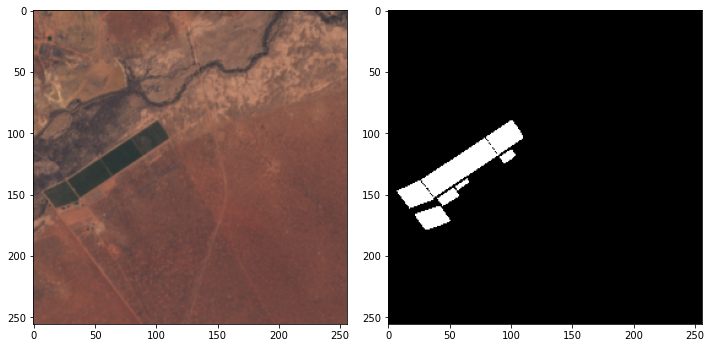

In [9]:
 def show_image(field:np.ndarray, mask:np.ndarray): #show image without augmentation
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field*2)
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()
    
show_image(field, mask)

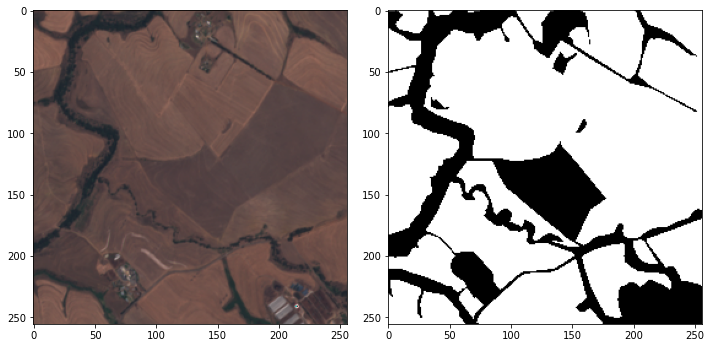

In [12]:
 def show_image(field:np.ndarray, mask:np.ndarray): #show image without augmentation
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field*2)
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()
    
show_image(field, mask)

## Transformations/Augmentations

We will then apply the different transformation and visualise the result.

#### CASE 1: Zooming the image

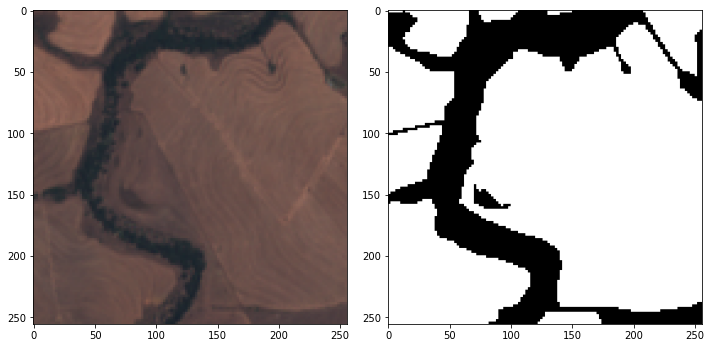

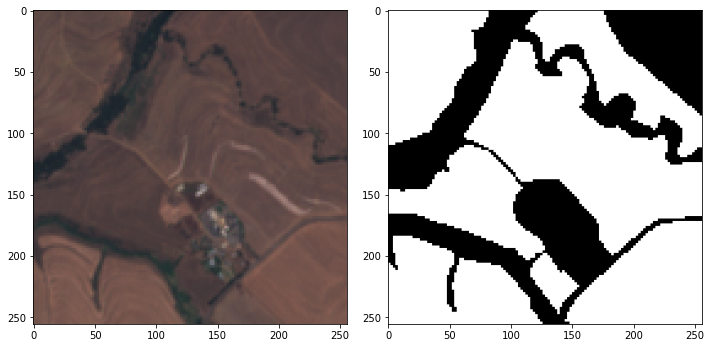

In [13]:
for idx in (0, 2): #zooming
    f,m = t_quartile(field, mask, idx=idx)
    show_image(f,m)

#### CASE 2: Rotating the image

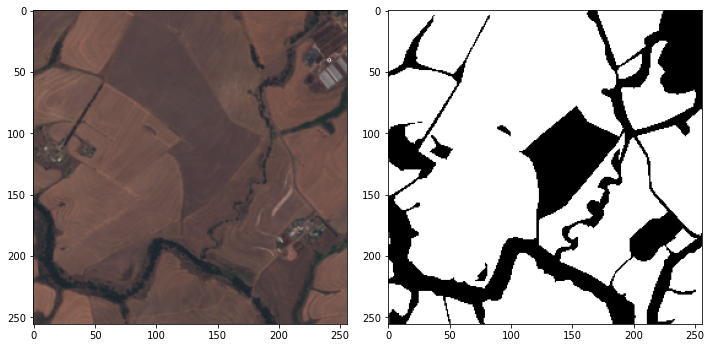

In [14]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

#### CASE 3: Flipping the image

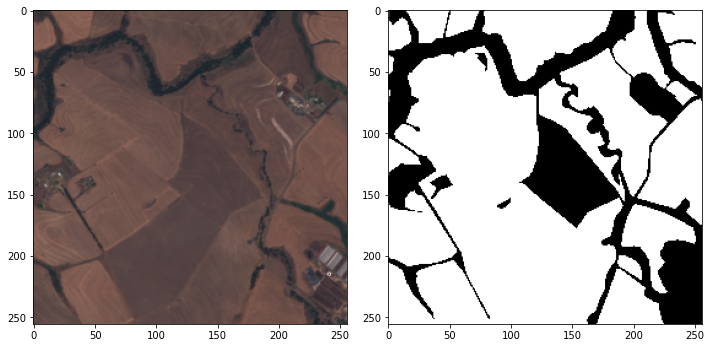

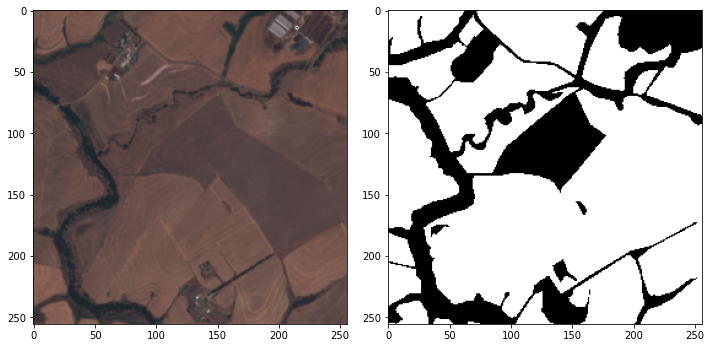

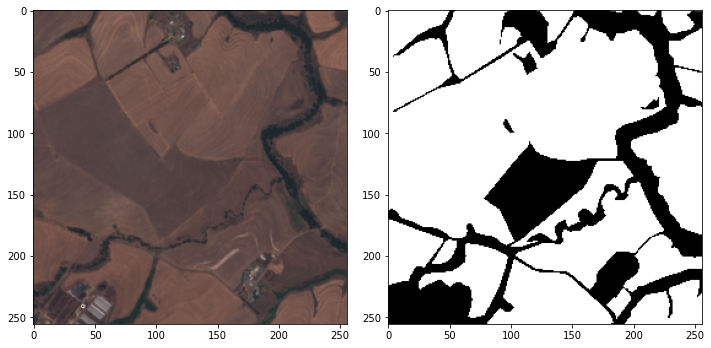

In [15]:
for idx in (0,1,2):
    f,m = t_flip(field, mask, idx=idx) #flipping
    show_image(f,m)

#### CASE 4: Blurring the image

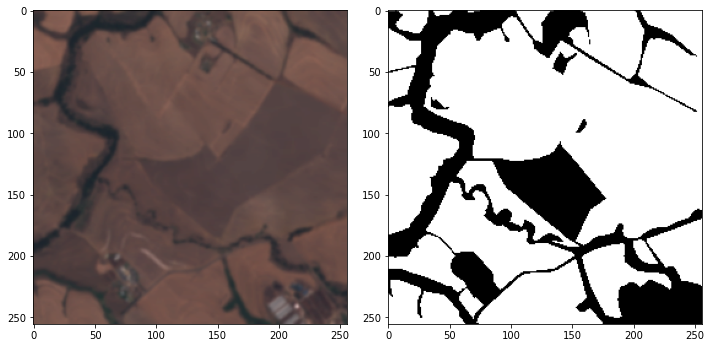

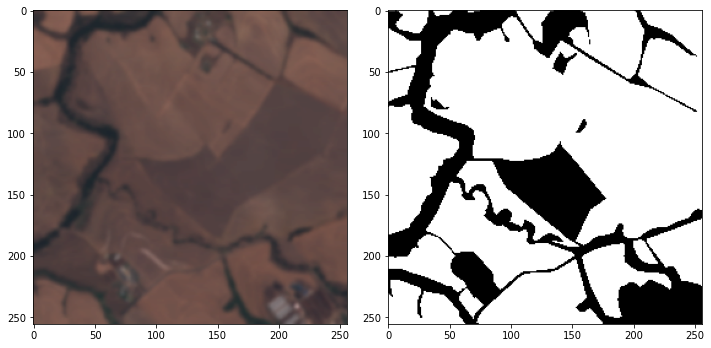

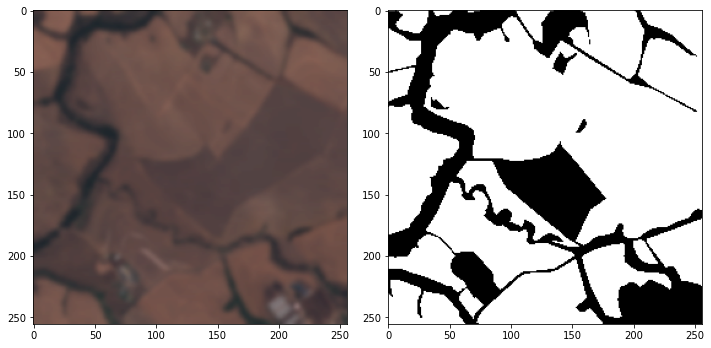

In [16]:
for sigma in (1, 5, 10):
    f,m = t_blur(field, mask, sigma=sigma) #blurring
    show_image(f,m)

#### CASE 5: Adjusting the contrast

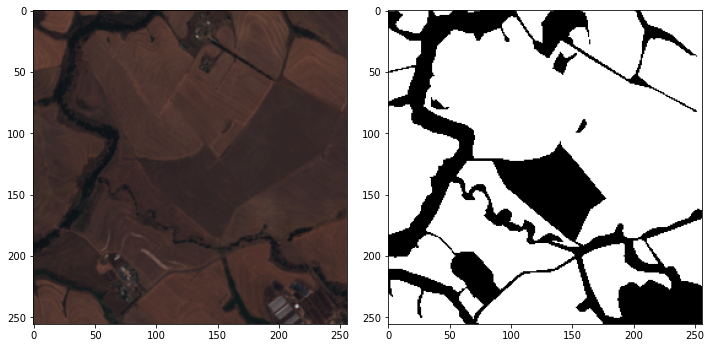

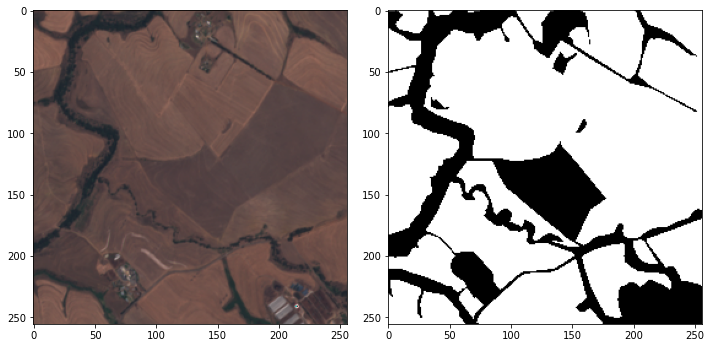

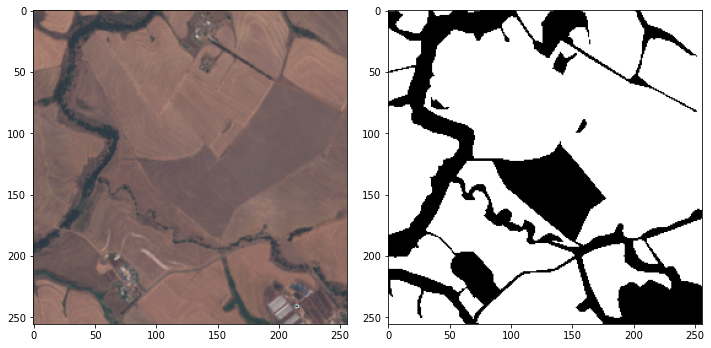

In [17]:
for gamma in (8, 10, 12):
    f,m = t_gamma(np.copy(field), mask, gamma=gamma) #adjusting contrast
    show_image(f,m)

Next, we will perform augmentation on the entire dataset. We will import some modules from the `agoro_field_boundary_detector` library to implement this.

Comments are added to expantiate on what the augmentation codes are doing.

In [13]:
"""Augment the dataset."""
#importing augmentation functions
from src.agoro_field_boundary_detector.augmentation import (
    get_random_noise,
    load_annotations,
    polygons_to_mask,
    t_linear,
    t_quartile,
    transform,
)

In [14]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    dupl: int = 2,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask.
    Every field is augmented dupl*5 times, where every 5 times includes:
     - Linear (no) transformation
     - Four quartile cuts of the input image
    Aside from these translation augmentations, a random noise is added, chosen from:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param dupl: Number of times to add random noise to the 5 translation augmentations
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    idx = 0
    for _ in range(dupl):
        for t, t_idx in (
            (t_linear, 0),
            (t_quartile, 0),
            (t_quartile, 1),
            (t_quartile, 2),
            (t_quartile, 3),
        ):
            n, n_idx = get_random_noise()
            field_t, mask_t = transform(
                field=field,
                mask=mask,
                translation=t,  # type: ignore
                t_idx=t_idx,
                noise=n,
                n_idx=n_idx,
            )
            # Save as PNG; slower but more memory efficient than pure numpy
            cv2.imwrite(write_folder +'/'+ f"fields/{prefix}_{idx}.png", cv2.cvtColor(field_t, cv2.COLOR_RGB2BGR))
            #Image.fromarray(np.uint8(field_t)).save(write_folder +'/'+ f"fields/{prefix}_{idx}.png")
            cv2.imwrite(write_folder +'/'+ f"masks/{prefix}_{idx}.png", mask_t*255)
            idx += 1


In [15]:
def main(
    fields: List[np.ndarray],
    masks: List[np.ndarray],
    prefixes: List[str],
    write_folder: Path,
    dupl: int = 2,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks.
    Every field is augmented dupl*5 times, where every 5 times includes:
     - Linear (no) transformation
     - Four quartile cuts of the input image
    Aside from these translation augmentations, a random noise is added, chosen from:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    :param dupl: Number of times to add random noise to the 5 translation augmentations
    """
    for field, mask, prefix in tqdm(
        zip(fields, masks, prefixes), total=len(prefixes), desc="Generating"
    ):
        generate(
            field=field,
            mask=mask,
            prefix=prefix,
            dupl=dupl,
            write_folder=write_folder,
        )

We will then repeat the process of augmentation. The code is just a replica of the previous one, generalised for all images

In [ ]:
%cd {images}

In [42]:
len(annotated_masks)

3899

In [16]:
#this takes approximately 30 mins
annotated_fields, annotated_masks = [], []
images= f"{data_path}/images/"

file_names = os.listdir(images)
for filename in file_names:
    try:
        name = os.path.basename(filename[:-4])
        field = np.asarray(Image.open(Path.cwd() / f"data/images/{name}.tif")) #opening source image
        with open(Path.cwd() / f"data/extracted_data/labels/{name}.geojson") as igj: #opening label
            data = json.load(igj)
        # if GDAL 3+
        crs = data["crs"]["properties"]["name"]
        # crs = "EPSG:4326" # if GDAL 2
        geoms = [feat["geometry"] for feat in data["features"]]

        # create empty mask raster based on the input raster
        rds = rioxarray.open_rasterio(Path.cwd() / f"data/images/{name}.tif").isel(band=0)
        rds.values[:] = 1
        rds.rio.write_nodata(0, inplace=True)

        # clip the raster to the mask
        mask = rds.rio.clip(geoms, crs, drop=False) #obtaining pixel values of the label
        mask = mask.values
        annotated_fields.append(field)
        annotated_masks.append(mask)
    except:
        pass

In [34]:
%cd "{data_path}/images"
%rm -rf .ipynb_checkpoint #remove jupyter checkpoints
# %rm -rf masks
# %rm -rf test_frames
# %rm -rf test_masks
# %rm -rf train_masks
# %rm -rf train_frames
# %rm -rf val_frames
# %rm -rf val_masks

/home/jovyan/Downloads/agoro-field-boundary-detector/notebooks/data/images


In [17]:
#create a folder for the augmented images
if not os.path.isdir(f"{data_path}/augmented"):
    os.makedirs(f"{data_path}/augmented")
if not os.path.isdir(f"{data_path}/augmented/fields"):
    os.makedirs(f"{data_path}/augmented/fields")
if not os.path.isdir(f"{data_path}/augmented/masks"):
    os.makedirs(f"{data_path}/augmented/masks")

In [18]:
images= f"{data_path}/images/"
NAMES=[]
file_names = os.listdir(images)
for filename in file_names:
    name = os.path.basename(filename[:-4])
    NAMES.append(name)

In [19]:
    main( #applying augmentation effects
        fields=annotated_fields,
        masks=annotated_masks,
        prefixes=NAMES,
        write_folder=data_path + '/augmented',
    ) #approximately 25 minutes

Generating: 100%|███████████████████████████| 3899/3899 [01:59<00:00, 32.62it/s]
